# Classifying Online Comments

## 1.1 Problem Statement 

The Conversation AI team, a research initiative founded by Jigsaw and Google (both a part of Alphabet) are working on tools to help improve online conversation. One area of focus is the study of negative online behaviors, like toxic comments (i.e. comments that are rude, disrespectful or otherwise likely to make someone leave a discussion). 

So far they’ve built a range of publicly available models served through the Perspective API, including toxicity. But the current models still make errors, and they don’t allow users to select which types of toxicity they’re interested in finding (e.g. some platforms may be fine with profanity, but not with other types of toxic content).

## 1.2. Objective

Build a model that can classify online comments. Possible class labels include: 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'non_toxic'

## 1.3 Workflow and Approach

1. Reading data and preprocessing steps
2. Exploratory Data Analysis
3. Predictive Modelling 

I am approaching this as a multi-label classification problem, prediction from 1 to more labels for each observation. The datasets include training and test sets which consist of 66,171 and 153,164 samples respectively. 

# Reading, Cleaning and Exploratory Data Analysis

Steps:
1. Importing dependencies (nltk, matplotlib, sklearn, seaborn, pandas, etc)
2. data cleaning (removing stopwords, non alphabetic characters, lowering comment texts)
3. Exploratory data analysis: Counting the number of observations or texts with no label, 1 label and more than 1 label
4. Seperating the training set into toxic_df for toxic comments and non_toxic_df for non toxic comments and getting the frequent words in both dataframes
5. Creating a column in the training dataframe to house all the labels of an observation as a list. E.g. [toxic, obscene]


In [36]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer


from collections import Counter

from IPython.display import display, Markdown, Latex

from theta import modelling as tm


multilabel_binarizer = MultiLabelBinarizer()
nbayes = MultinomialNB()
svm = LinearSVC(random_state=42)

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test 2.csv')
test_labels = pd.read_csv('test_labels.csv')

train_df.head(2)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/oluwaseyi.ogunnowo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0


In [37]:
test_df.head(2)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...


In [38]:
dfs = [train_df, test_df]
for i in dfs:
    print(i.isnull().sum(), i.shape)

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64 (159571, 8)
id              0
comment_text    0
dtype: int64 (153164, 2)


In [39]:
#text cleaning function
def clean_text(text):
    
    text = text.lower()
    text = re.sub("[^a-zA-Z]+", " ", text)
    text = tokenizer.tokenize(text)
    text = [i for i in text if i not in stop_words]
    text = ' '.join(text)
    
    return text

train_df['comment_text'] = train_df['comment_text'].apply(lambda x: clean_text(x))
train_df['total'] = train_df.iloc[:,1:7].sum(axis = 1)

#identifying number of comments per toxicity category
toxicity_df = pd.DataFrame(train_df['total'].value_counts()).reset_index(drop = False)
toxicity_df = toxicity_df.rename({'index':'num_of_labels'}, axis = 1)
toxicity_df

,num_of_labels,total
0,0,143400
1,1,6473
2,3,4647
3,2,3510
4,4,1446
5,5,95


### Count of comments by number of labels

<AxesSubplot:xlabel='num_of_labels', ylabel='total'>

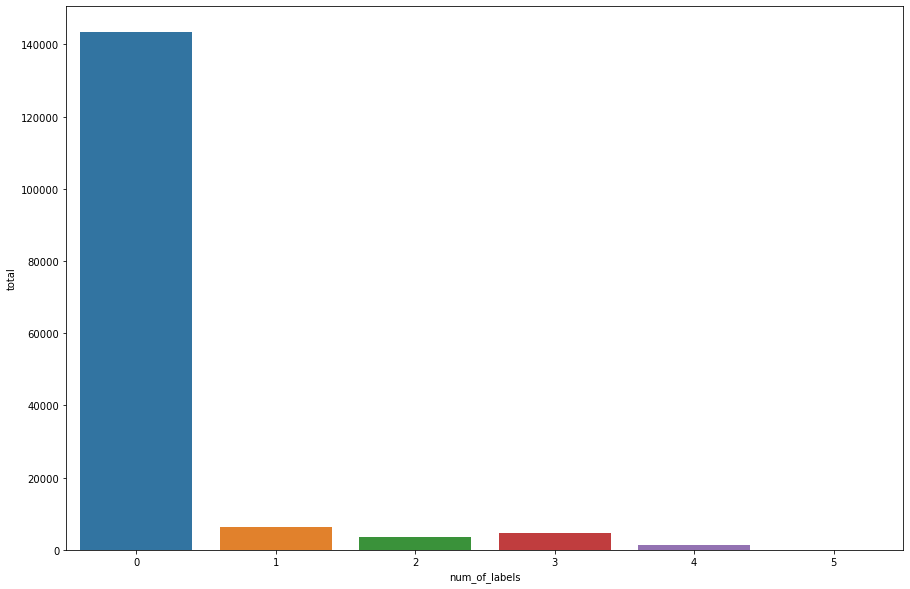

In [40]:
display(Markdown('### Count of comments by number of labels'))
plt.figure(figsize = (15,10))
sns.barplot(y = 'total', x = 'num_of_labels', data = toxicity_df)

### Frequency of top 50 words in toxic_df

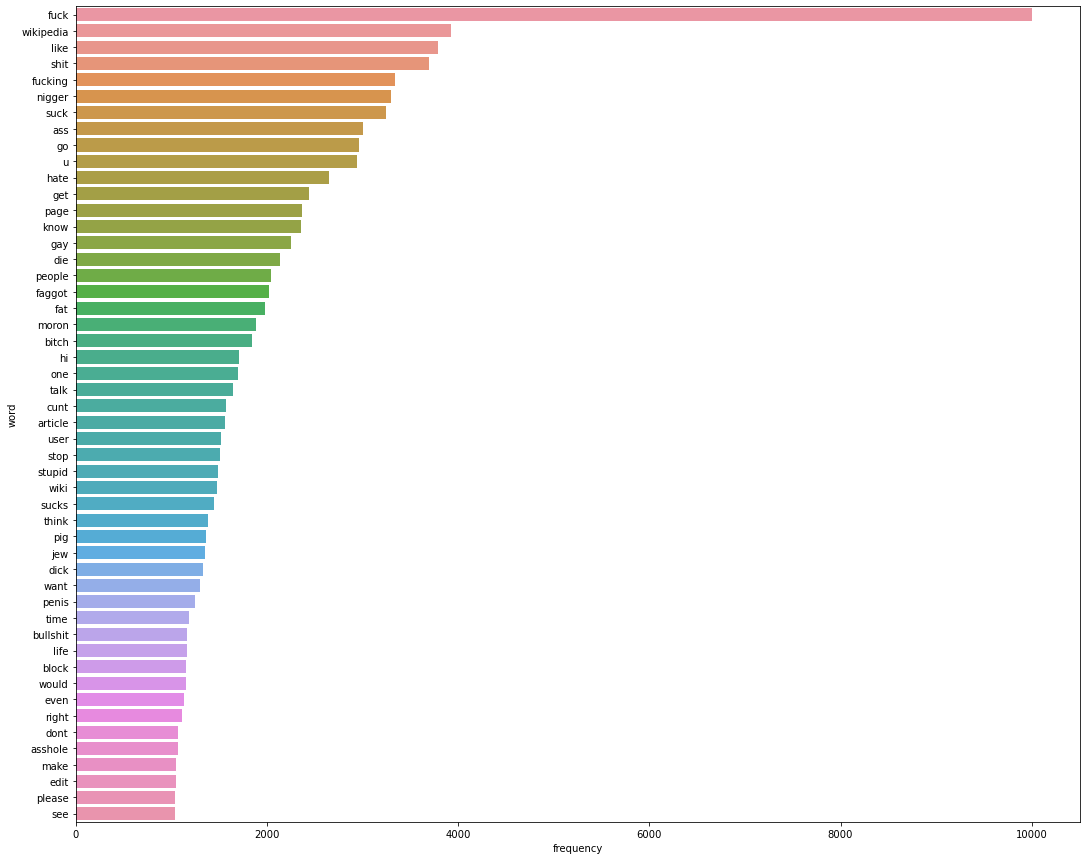

In [41]:
toxic_df = train_df.loc[train_df['total'] > 0]
non_toxic_df = train_df.loc[train_df['total'] == 0]

def word_frequency(df = 'df', column = 'pd.Series', terms = 'n', size = ('tuple')):
    

    name =[x for x in globals() if globals()[x] is df][0]

    
    texts = ' '.join([i for i in df[column]])
    texts = texts.split()
    frequency = Counter(texts)
    word_df = pd.DataFrame({'word':frequency.keys(),
                           'frequency':frequency.values()})
    
    if terms:
        display(Markdown('### Frequency of top {} words in {}'.format(terms, name)))
        top_n = word_df.nlargest(columns = 'frequency', n = terms)
        plt.figure(figsize = size)
        sns.barplot(y = 'word', x = 'frequency', data = top_n)
    else:
        display(Markdown('### Frequency of words in {}'.format(name)))
        plt.figure(figsize = size)
        sns.barplot(y = 'word', x = 'frequency', data = word_df)
    
    

word_frequency(df = toxic_df, column = 'comment_text', terms = 50, size = (18,15))

### Frequency of top 50 words in non_toxic_df

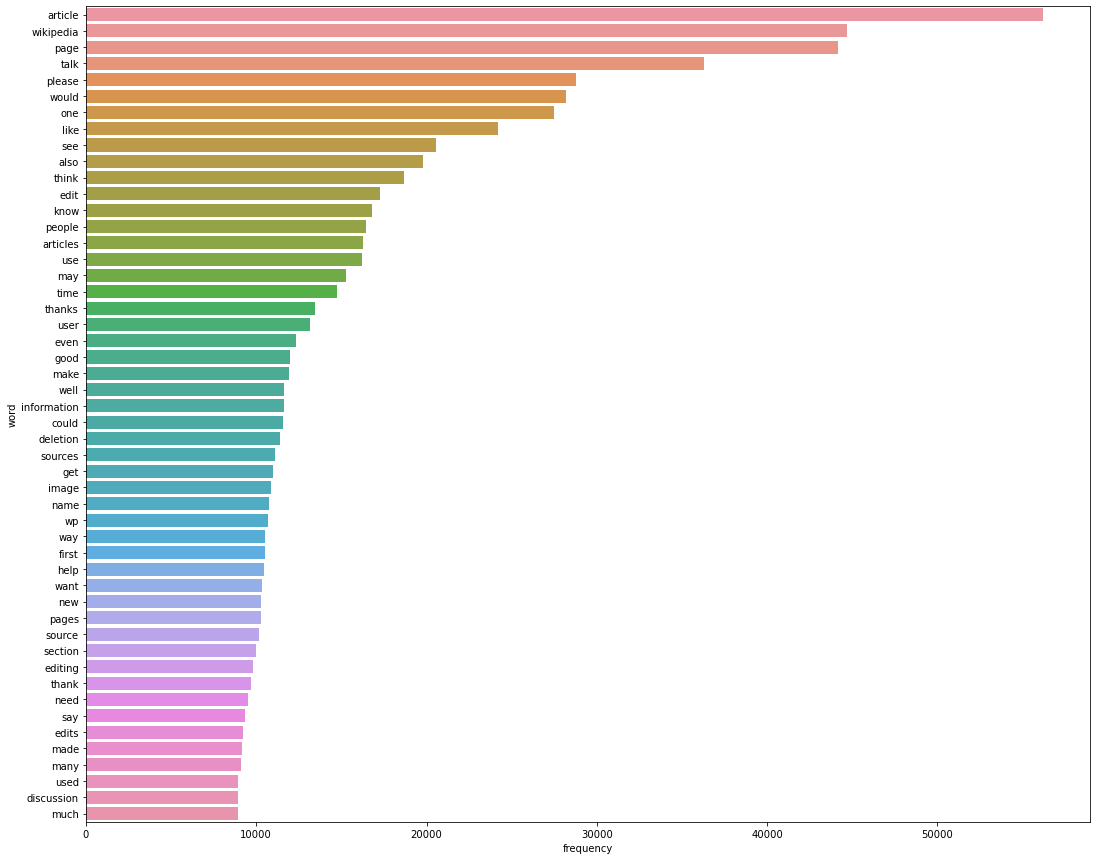

In [42]:
word_frequency(df = non_toxic_df, column = 'comment_text', terms = 50, size = (18,15))

In [43]:
columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

for column in train_df[columns]:
    train_df[column] = train_df[column].map({1:column,
                                            0:None})

    
labels_list = train_df.iloc[:,2:8]

labels_list = labels_list.values.tolist()
labels_list

result = []

for i in labels_list:
    result.append([j for j in i if j is not None])

train_df['toxic_labels'] = result

## Key Takeaways

We are working with two seperate dataframes of the same kind of data in this project. The first is train_df consisting of 66,171 observations and 8 columns and test set consisting of 153,164 observations and 2 columns. None of these dataframes have null values, thankfully :)

I summed the columns of the labels in the training set for each observation to give me a count of labels for each observation. More than 60% of comments have 0 labels, meaning that these are not toxic. a few have just 1 label, and the rest, have multiple labels. The highest number of labels for a text is 4. meaning a comment text has 4 different predictions/ labels attached to it. 

I also visualized words that characterize toxic and non toxic comments. The frequent words are indicative of these two categories. See the chart above for the kind of words associated with these two dataframes. 

# Modelling

As mentioned, the data in the training set is unbalanced, so we will employ sampling to select messages that are not toxic from the training set and all toxic messages from the same dataset. 

Steps: 
1. binarizing dependent variables 
2. vectorizing texts
3. splitting training set into train and validation sets 
4. model benchmarking

In [44]:
toxic_df = train_df.loc[train_df['total'] > 0]
non_toxic_df = train_df.loc[train_df['total'] == 0].head(50000)

for row in non_toxic_df['toxic_labels']:
    row = row.append('non_toxic')

In [45]:
train_df = pd.concat([toxic_df, non_toxic_df], axis = 0).sample(frac = 1)
train_df = train_df.reset_index(drop = True)
train_df = train_df[['comment_text', 'toxic_labels']]
train_df

,comment_text,toxic_labels
0,cozumel added citation needed tag information ...,[non_toxic]
1,utc seriously fuck guy fucking face fucking si...,"[toxic, severe_toxic, obscene, insult]"
2,mum turtle article mum turtle flagged deletion...,[non_toxic]
3,adminship know asked previously would interest...,[non_toxic]
4,discussion well would joke say picked good id ...,[non_toxic]
...,...,...
66166,biggest vandalist must leave administrator wor...,"[toxic, insult]"
66167,aha quite interesting thanks bringing attentio...,[non_toxic]
66168,pretend psychic one knows ghirla thinks harass...,[non_toxic]
66169,except said bottom two america get much cleare...,[non_toxic]


In [10]:
multilabel_binarizer.fit(train_df['toxic_labels'])

# transform target variable
y = multilabel_binarizer.transform(train_df['toxic_labels'])

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.1, max_features=10000)

x_train, x_val, y_train, y_val = train_test_split(train_df['comment_text'], y, test_size = 0.1)

# create TF-IDF features
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_val_tfidf = tfidf_vectorizer.transform(x_val)

In [11]:
svm_clf = MultiOutputClassifier(svm, n_jobs=-1)
nbayes_clf = MultiOutputClassifier(nbayes, n_jobs=-1)

In [14]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, recall_score

def benchmark(x_train, x_test, y_train, y_test, algs = ['list of algs']):
    
    train = []
    test = []
    name = []
    recall = []
    precision = []
    f1 = []
    
    for alg in algs:
        name.append(type(alg).__name__)
        print('\n')
        print('algorithm:', alg)
        
        
        training = alg.fit(x_train, y_train)
        training_score = alg.score(x_train, y_train)
        y_pred = alg.predict(x_test)
        test_score = alg.score(x_test, y_test)
        
        f1.append(f1_score(y_test, y_pred, average = 'micro'))
        recall.append(recall_score(y_test, y_pred, average = 'micro'))
        precision.append(precision_score(y_test, y_pred, average = 'micro'))
        
        print(training_score)
        print(test_score)
        print('\n')
        print('training and test score difference:', training_score - test_score)
        if (training_score - test_score) > 0.1:
            print('model likely overfitting, investigate further')
            
        train.append(training_score)
        test.append(test_score)
        
    benchmark = pd.DataFrame({'alg_name': name,
                             'train_score':train,
                             'test_score':test,
                             'precision':precision,
                             'recall':recall,
                             'f1':f1}, columns = ['alg_name', 'train_score', 'test_score', 'precision', 'recall', 'f1'])
        
    return benchmark

benchmark(x_train_tfidf, x_val_tfidf, y_train, y_val, algs = [svm_clf, nbayes_clf])



algorithm: MultiOutputClassifier(estimator=LinearSVC(random_state=42), n_jobs=-1)
0.8774872802377714
0.8121789060139015


training and test score difference: 0.06530837422386992


algorithm: MultiOutputClassifier(estimator=MultinomialNB(), n_jobs=-1)
0.8143838261716454
0.8008461770927773


training and test score difference: 0.01353764907886812


,alg_name,train_score,test_score,precision,recall,f1
0,MultiOutputClassifier,0.877487,0.812179,0.895769,0.849754,0.872155
1,MultiOutputClassifier,0.814384,0.800846,0.895879,0.806459,0.848821


In [27]:
def model_pipeline(text):
    
    text = text.apply(lambda x: clean_text(x))
    vectors = tfidf_vectorizer.transform(text)
    predictions = svm_clf.predict(vectors)
    predictions = multilabel_binarizer.inverse_transform(predictions)
    
    cleaned = []
    
    for i in predictions:
        cleaned.append(list(i))
        
    return cleaned


predictions = model_pipeline(test_df['comment_text'])
test_df['predictions'] = predictions

In [30]:
test_df.head(100)

,id,comment_text,predictions
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,"[insult, obscene, toxic]"
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,[non_toxic]
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",[non_toxic]
3,00017563c3f7919a,":If you have a look back at the source, the in...",[non_toxic]
4,00017695ad8997eb,I don't anonymously edit articles at all.,[non_toxic]
...,...,...,...
95,0023f3f84f353bce,""" \n\n == Main towns that are not so main == \...",[non_toxic]
96,002586bdf3280356,""" \n\n my comments follow, bluewillow991967 -...",[non_toxic]
97,0025a91b6955f1a5,""" \n\n == Halliday == \n\n Good to see another...",[non_toxic]
98,0025c49d87d9a18f,""" \n ::: That Stephen Barrett is not Board Cer...",[non_toxic]


## Key takeaways

Two models were compared in a benchamrking process that focused on classification evaluation metrics. These metrics include train_score, test_score, f1_score, recall and precision. The LinearSVC based model, outperformed the MultinomialNB based model in virtually all metrics mentioned. However the metric of focus is the f1_score which is the harmonic mean of the recall and precision metrics. 

The LinearSVC based classifier was then used to make predictions on the test set. 

In [46]:
import pickle
with open('svm_model_pkl', 'wb') as files:
    pickle.dump(svm_clf, files)

In [47]:
test_df.to_csv('predictions.csv')